Student id: 2065700

Student name: Himani Gurung

Sentiment Analysis using Recurrent Neural Network

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/AI_Dataset/Twitter Dataset/train.csv"

In [ ]:
#Import all necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import emoji
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Understanding


In [ ]:
df = pd.read_csv(data_path)
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [ ]:
# checking if there is any null values in df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
# checking missing values
df.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
# label distribution
label_count = df['label'].value_counts()
label_count

0    29720
1     2242
Name: label, dtype: int64

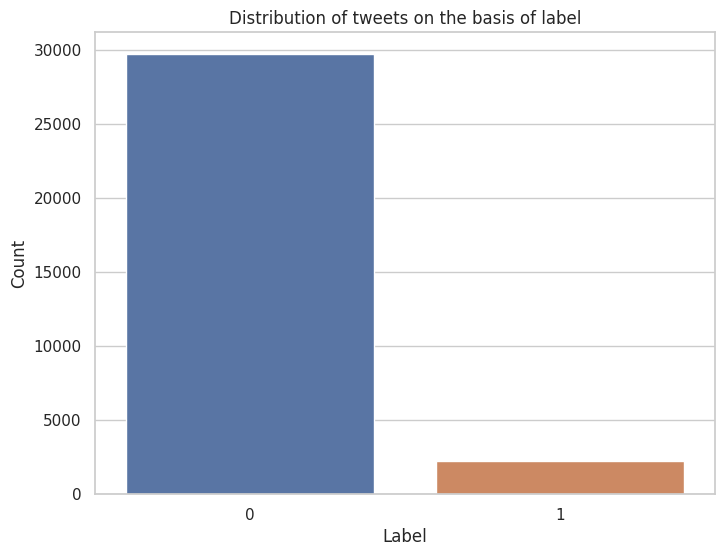

In [ ]:
# Create a countplot to visualize the distribution of negative and positive sentiments
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# 'label' is the column containing labels for tweets (label 0 is for non racist/sexist tweets, label 1 is for racist/sexist tweets)
sns.countplot(x='label', data=df)

# Adding labels and a title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of tweets on the basis of label')

# plt.legend(label_count.keys(), loc='upper right')

# Display the plot
plt.show()

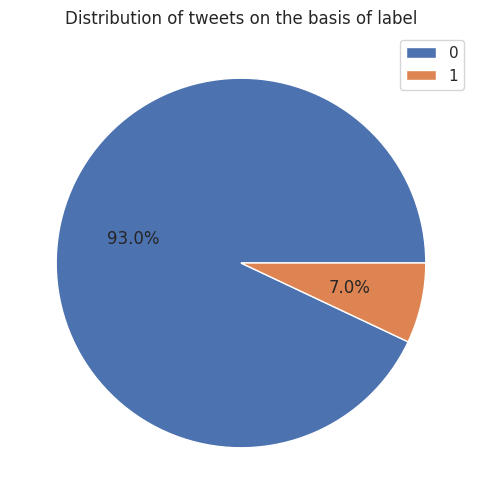

In [ ]:
# craeting a pie-chart for the label distribution
plt.figure(figsize=(6, 6))
plt.pie(label_count, autopct='%1.1f%%')

plt.title('Distribution of tweets on the basis of label')
# adding legend for the chart
plt.legend(label_count.keys(), loc='upper right')

# Display the plot
plt.show()

In [ ]:
# Split into dependent (Y) and independent (X) variables
X = df['tweet']   # Assign the 'tweet' column to x
y = df['label']   # Assign the 'label' column to Y


# Data Cleaning

In [ ]:
# Remove emojis using a regular expression
emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U0001F004-\U0001F0CF"
                               u"\U0001F170-\U0001F251"
                               "]+", flags=re.UNICODE)


In [ ]:
# functions to remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
# function to clean the text data
def clean_text(text):
    text = re.sub(r'@[\w_]+', '', text)  # remove user mentions
    text = re.sub('[^A-Za-z\s]', '', text)  # remove special characters
    text = re.sub('[^0-9A-Za-z ]', '' , text) # remove punctuations
    text = re.sub(r'\d+', '', text)   # remove digits
    text = emoji_pattern.sub('', text)  # remove emojis

    # Convert text to lowercase
    text = text.lower()

    # Removing unwanted spaces
    text = text.strip()   # remove white spaces at the beginning and end
    text = re.sub(" +", " ", text)    # remove white spaces from anywhere in the string

    return text


# **Data Pre-processing**

In [ ]:
# Apply the clean_text function to the 'tweet' column in your dataset
df['cleaned_tweet'] = df['tweet'].apply(clean_text)

df['cleaned_tweet'] = df['cleaned_tweet'].str.split()


# Remove stop words with NLTK
stop_words = set(stopwords.words('english'))
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Apply stemming to the cleaned text data
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])


# Create a list of cleaned texts
cleaned_tweet = [" ".join(tokens) for tokens in df['cleaned_tweet']]
df

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,"[father, dysfunct, selfish, drag, kid, dysfunc..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[thank, lyft, credit, cant, use, caus, dont, o..."
2,3,0,bihday your majesty,"[bihday, majesti]"
3,4,0,#model i love u take with u all the time in ...,"[model, love, u, take, u, time, ur]"
4,5,0,factsguide: society now #motivation,"[factsguid, societi, motiv]"
...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,"[ate, isz, youuu]"
31958,31959,0,to see nina turner on the airwaves trying to...,"[see, nina, turner, airwav, tri, wrap, mantl, ..."
31959,31960,0,listening to sad songs on a monday morning otw...,"[listen, sad, song, monday, morn, otw, work, sad]"
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...","[sikh, templ, vandalis, calgari, wso, condemn,..."


In [ ]:
# maximum length of tweets before cleaning
max_length = max(len(tweet) for tweet in df["tweet"])

print("Max length of a single tweet is then : ", max_length)

Max length of a single tweet is then :  274


In [ ]:
# maximum length of tweets after cleaning
max_length_cleaned = max(len(tweet) for tweet in df["cleaned_tweet"])

print("Max length of a single tweet is now : ", max_length_cleaned)

Max length of a single tweet is now :  23


In [ ]:
# Allocate dictionary size
vocab_size = 3000

# Create a tokenizer
tokenizer = Tokenizer(num_words=vocab_size)

# Fit the tokenizer on the text
tokenizer.fit_on_texts(cleaned_tweet)

# Convert text to sequences of integers (one-hot encoding)
one_hot_encoded = tokenizer.texts_to_sequences(cleaned_tweet)

# Define the maximum sequence length (adjust as needed)
max_sequence_length = 50

# Pad sequences to have the same length
padded_sequences = pad_sequences(one_hot_encoded, maxlen=max_sequence_length, padding='pre')

# 'padded_sequences' now contains your one-hot encoded and padded text data
padded_sequences

array([[   0,    0,    0, ..., 1796,  125,  188],
       [   0,    0,    0, ...,  420,   28,  857],
       [   0,    0,    0, ...,    0,   20, 2808],
       ...,
       [   0,    0,    0, ...,   58,   25,   68],
       [   0,    0,    0, ..., 1417, 1116,  366],
       [   0,    0,    0, ...,    0,    5,   55]], dtype=int32)

In [ ]:
#convert in numpy arrays.
x = np.array(padded_sequences)
y = np.array(y)

# **Build a RNN model**

In [ ]:
#Splitting the Dataset into Train and Test set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
#create the model using LSTM
model = Sequential()
model.add(Embedding(vocab_size,64,input_length = len(padded_sequences[0])))  #adding an embedding layer to convert integer-encoded words into dense vectors of 64 dimensions.
model.add(LSTM(100))   #adding LSTM layers with 100 units
model.add(Dropout(0.5))   # dropping 50% of connections
model.add(Dense(1,activation="relu",kernel_regularizer=regularizers.l2(0.01)))

#to compile the model
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

#summary of model
model.summary()

#training the model
history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, batch_size = 60)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            192000    
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 258,101
Trainable params: 258,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
427/427 [==============================] - 72s 146ms/step - loss: 0.2205 - accuracy: 0.9424 - val_loss: 0.2195 - val_accuracy: 0.9562
Epoch 2/10
427/427 [=================

In [ ]:
# saving the trained model
model.save('new_model')

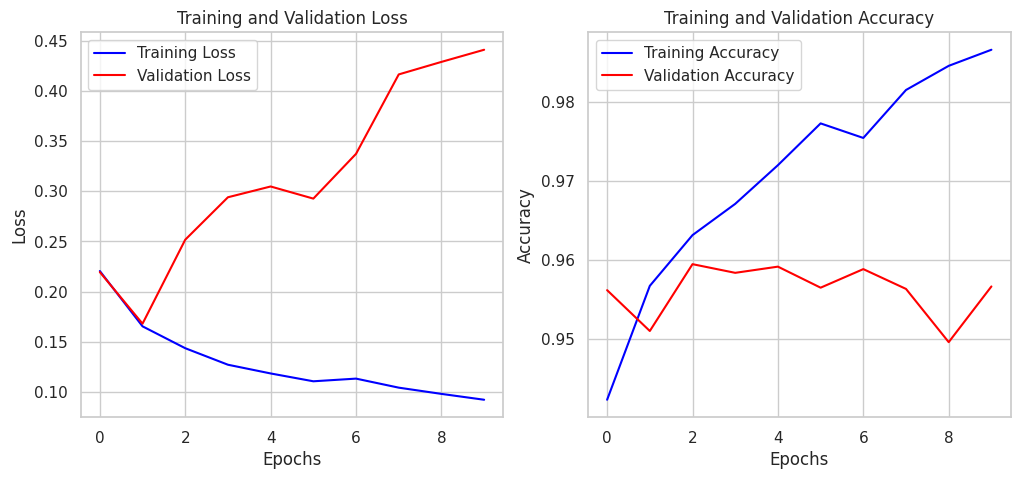

In [ ]:
# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(training_loss, label='Training Loss', color='blue')
ax1.plot(validation_loss, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(training_accuracy, label='Training Accuracy', color='blue')
ax2.plot(validation_accuracy, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


# **Evaluate the model**

In [ ]:
# Import necessary libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test data
y_pred = model.predict(x_test)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


400/400 [==============================] - 9s 20ms/step
Accuracy: 0.9792
Precision: 0.8790
Recall: 0.8258
F1 Score: 0.8516
Confusion Matrix:
[[11756   105]
 [  161   763]]


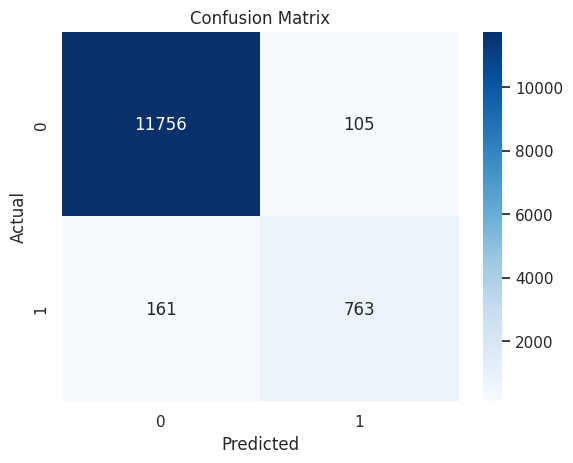

In [ ]:
# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Testing the model

In [ ]:
# Loading LSTM model
from tensorflow.keras.models import load_model

# Load your previously trained model
model = load_model('new_model')

import pandas as pd
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer


test_file = "/content/drive/MyDrive/AI_Dataset/Twitter Dataset/test.csv"
stop_words = set(stopwords.words('english'))

# Load the test dataset
test_data = pd.read_csv(test_file)

# Clean and preprocess the test data
test_data['tweet'] = test_data['tweet'].apply(lambda x: re.sub('[^a-zA-Z\ ]', ' ', emoji.demojize(x)))
test_data['tweet'] = test_data['tweet'].apply(lambda x: remove_urls(x))
test_data['tweet'] = test_data['tweet'].apply(lambda x: x.lower())
test_data['tweet'] = test_data['tweet'].apply(lambda x: x.split())
test_data['tweet'] = test_data['tweet'].apply(lambda x: [word for word in x if word not in stop_words])
test_data['tweet'] = test_data['tweet'].apply(lambda x: [stemmer.stem(word) for word in x])
test_data['tweet'] = test_data['tweet'].apply(lambda x: ' '.join(x))

# Tokenize and pad the test data
max_words = 3000
maxlen = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(test_data['tweet'])
test_sequences = tokenizer.texts_to_sequences(test_data['tweet'])
test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

# Make predictions on the test data using the LSTM model
predictions = model.predict(test_sequences)

538/538 [==============================] - 9s 16ms/step


In [ ]:
predictions

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
threshold = 1

positive_count = 0
negative_count = 0

for prediction in predictions:
    if prediction < threshold:
        positive_count += 1
    else:
        negative_count += 1

print("Non racist/sexist:", positive_count)
print("Racist/sexist:", negative_count)

Non racist/sexist: 16824
Racist/sexist: 373
